## **CNNs for Text Classification with PyTorch**

## Dataset Preparation

#### **Download  & explore movies dataset**

In [ ]:
import pickle

with open("movies_dataset.pkl", "rb") as f:
    movies = pickle.load(f)

x, y = movies.data, movies.target
print(len(x), len(y))

2000 2000


# Inspect the data distribution

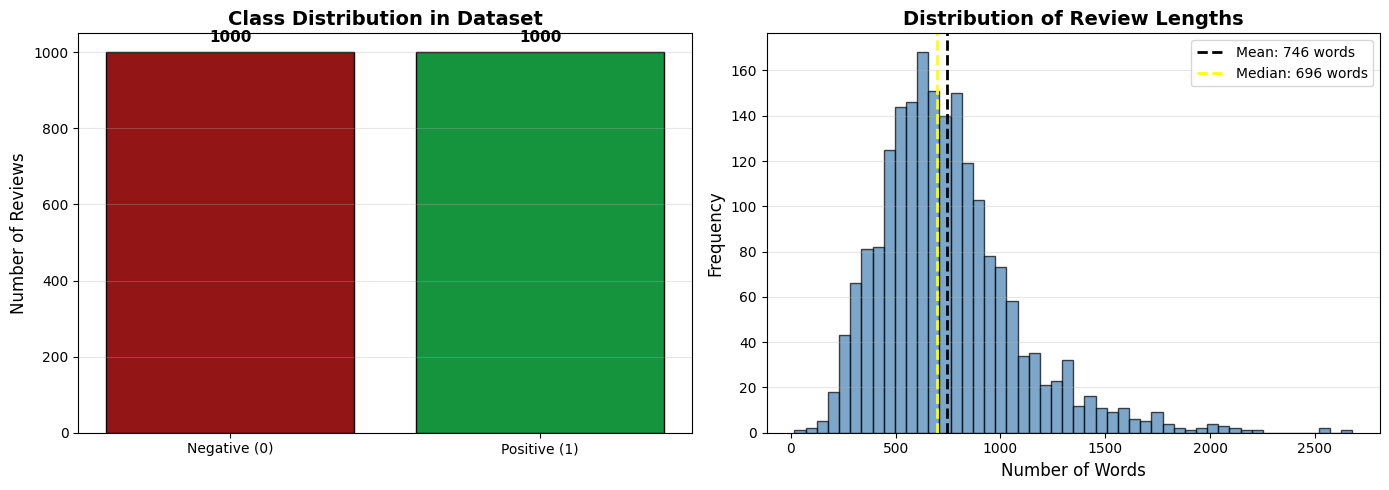

DATASET SUMMARY
Total reviews: 2000
Negative reviews: 1000 (50.0%)
Positive reviews: 1000 (50.0%)

Review Length Statistics:
  Min length: 17 words
  Max length: 2678 words
  Mean length: 746.3 words
  Median length: 696.5 words
  Std deviation: 328.3 words


In [ ]:
from matplotlib import pyplot as plt
import numpy as np

# Plot 1: Class Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Class distribution
class_counts = np.bincount(y)
axes[0].bar(['Negative (0)', 'Positive (1)'], class_counts, color=['#941515', '#15943d'], edgecolor='black')
axes[0].set_ylabel('Number of Reviews', fontsize=12)
axes[0].set_title('Class Distribution in Dataset', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
# Add count labels on bars
for i, count in enumerate(class_counts):
    axes[0].text(i, count + 20, str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 2: Review Length Distribution
review_lengths = [len(str(review).split()) for review in x]
axes[1].hist(review_lengths, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].axvline(np.mean(review_lengths), color='black', linestyle='--', linewidth=2, label=f'Mean: {np.mean(review_lengths):.0f} words')
axes[1].axvline(np.median(review_lengths), color='yellow', linestyle='--', linewidth=2, label=f'Median: {np.median(review_lengths):.0f} words')
axes[1].set_xlabel('Number of Words', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Review Lengths', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("="*60)
print("DATASET SUMMARY")
print("="*60)
print(f"Total reviews: {len(x)}")
print(f"Negative reviews: {class_counts[0]} ({class_counts[0]/len(x)*100:.1f}%)")
print(f"Positive reviews: {class_counts[1]} ({class_counts[1]/len(x)*100:.1f}%)")
print(f"\nReview Length Statistics:")
print(f"  Min length: {min(review_lengths)} words")
print(f"  Max length: {max(review_lengths)} words")
print(f"  Mean length: {np.mean(review_lengths):.1f} words")
print(f"  Median length: {np.median(review_lengths):.1f} words")
print(f"  Std deviation: {np.std(review_lengths):.1f} words")
print("="*60)

In [ ]:
import spacy
import re
from tqdm import tqdm

# Load spaCy model — for English, for Greek you may need something like "el_core_news_sm"
nlp = spacy.load("en_core_web_sm", disable=["ner","parser"])
# disabling parser and ner may speed up processing since you only need POS + lemma

docs = []
for doc_text in tqdm(x):
    # Remove non-word characters (punctuation etc)
    doc_clean = re.sub(r'\W', ' ', str(doc_text))
    # Remove single characters (optional)
    doc_clean = re.sub(r'\s+[a-zA-Z]\s+', ' ', doc_clean)
    # Collapse multiple spaces
    doc_clean = re.sub(r'\s+', ' ', doc_clean, flags=re.I)
    # Lowercase
    doc_clean = doc_clean.lower().strip()

    # Process with spaCy
    doc = nlp(doc_clean)
    tokens = []
    for token in doc:
        # filter: only alphabetic tokens, non-stopwords, maybe length > 1
        if token.is_alpha and not token.is_stop:
            tokens.append(token.lemma_)
    # Reconstruct document string
    docs.append(" ".join(tokens))

print("\nOriginal review text:\n{}".format(x[0]))
print("\nFiltered review text:\n{}".format(docs[0]))
print("\nLabel:\n", y[0])

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:21<00:00, 14.15it/s]


Original review text:
arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . 
it's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? 
once again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . 
in this so called dark thriller , the devil ( gabriel byrne ) has come upon earth , to impregnate a woman ( robin tunney ) which happens every 1000 years , and basically destroy the world , but apparently god has chosen one man , and that one man is jericho cane ( arnold himself ) . 
with the help of a trusty sidekick ( kevin pollack ) , they will stop at nothing to let the devil take over the world ! 
parts of this are actually so absurd , that they would fit right in with dogma . 
yes

In [ ]:
from sklearn.model_selection import train_test_split

# 1️⃣ Split into train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
        docs, y, test_size=0.3, random_state=2025)

# 2️⃣ Split temp into validation (10%) and test (20%)
# 10% of total = 10/30 = 1/3 of temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=(2/3), random_state=2025)

print(len(X_train), len(X_val), len(X_test))

1400 200 400


#### **Use spacy for sentence splitting & tokenization**

In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from tqdm import tqdm

nlp = spacy.load('en_core_web_sm',disable=["tagger", "parser","ner", "lemmatizer"])
nlp.add_pipe('sentencizer')

def tokenize_samples(samples):

  tokenized_samples = []
  for i in tqdm(range(len(samples))):
    doc = nlp(samples[i])  # Tokenize the sample into sentences
    tokens = []
    for sent in doc.sents:
      for tok in sent:  # Iterate through the words of the sentence
        # Filter out noise (newlines, special chars) and stop words
        if '\n' in tok.text or "\t" in tok.text or "--" in tok.text or "*" in tok.text or tok.text.lower() in STOP_WORDS:
          continue
        if tok.text.strip(): # Check if token is not just whitespace
          tokens.append(tok.text.replace('"',"'").strip().lower()) # Normalize quotes and convert to lowercase
    tokenized_samples.append(tokens)

  return tokenized_samples

X_train_tokenized = tokenize_samples(X_train)
X_val_tokenized = tokenize_samples(X_val)
X_test_tokenized = tokenize_samples(X_test)

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:14<00:00, 27.50it/s]


In [ ]:
import numpy as np
# Get mean and std for length on training set
print('Average length of samples: {}'.format(np.mean([len(x) for x in X_train_tokenized])))
print('Std length of samples: {}'.format(np.std([len(x) for x in X_train_tokenized])))
print('#Samples with length > 1000: {} \n'.format(np.sum([len(x) > 1000 for x in X_train_tokenized])))
print('X_example: {}'.format(X_train_tokenized[0]))

Average length of samples: 304.35285714285715
Std length of samples: 132.74889208192886
#Samples with length > 1000: 1 

X_example: ['movie', 'like', 'day', 'seven', 'night', 'mad', 'talented', 'people', 'like', 'harrison', 'ford', 'anne', 'heche', 'ivan', 'reitman', 'lot', 'hard', 'work', 'script', 'worth', 'cent', 'script', 'write', 'michael', 'browning', 'decide', 'instead', 'think', 'new', 'idea', 'rehash', 'lot', 'cliche', 'omit', 'slight', 'bit', 'character', 'development', 'throw', 'drug', 'deal', 'pirate', 'provide', 'high', 'level', 'action', 'sequence', 'explosion', 'good', 'script', 'high', 'profile', 'actor', 'truman', 'instance', 'day', 'seven', 'night', 'simply', 'waste', 'let', 'harrison', 'ford', 'anne', 'heche', 'island', 'll', 'feisty', 'magazine', 'editor', 'll', 'crusty', 'old', 'pilot', 'wait', 'fianc', 'david', 'schwimmer', 'wait', 'fianc', 'harrison', 'ford', 'crash', 'island', 'know', 'll', 'vacation', 'spot', 'll', 'yessssss', 'll', 'crash', 'island', 'funny', 

### Build Vocabulary
- Create vocabulary of the MAX_WORDS most common words and set words as indexes corresponding to the vocabulary.
- Also, truncate or pad sequences to MAX_SEQUENCE_LENGTH

In [ ]:
from collections import Counter

MAX_SEQUENCE_LENGTH = 300 # Truncate or pad sequences to this length
MAX_WORDS = 20000 # Size of vocabulary

# Build vocabulary from tokens in X_train_tokenized
all_tokens = [token for sentence in X_train_tokenized for token in sentence]
token_counts = Counter(all_tokens)

# Initialize vocabulary with special tokens <pad> (padding token) and <unk> (unknown token)
vocab = {"<pad>": 0, "<unk>": 1}

# Sort tokens by frequency in descending order and add to vocab starting from 2
for i, (token, _) in enumerate(token_counts.most_common(MAX_WORDS), start=2):
    vocab[token] = i

# Encode and pad each sentence
def encode_sentence(sentence, vocab, max_length=250):
    # Map each token to its vocabulary ID or <unk> if not in vocab
    encoded = [vocab.get(token, vocab["<unk>"]) for token in sentence]
    # Pad or truncate to max_length
    return encoded[:max_length] + [vocab["<pad>"]] * max(0, max_length - len(encoded))

# Apply encoding and padding to each sentence in X_train_tokenized
train_data = [encode_sentence(sentence, vocab, MAX_SEQUENCE_LENGTH) for sentence in X_train_tokenized]
val_data = [encode_sentence(sentence, vocab, MAX_SEQUENCE_LENGTH) for sentence in X_val_tokenized]
test_data = [encode_sentence(sentence, vocab, MAX_SEQUENCE_LENGTH) for sentence in X_test_tokenized]

In [ ]:
len(vocab)

20002

In [ ]:
# Reverse lookup check - Verify which words correspond to ID 0, 1, and 100
print(list(vocab.keys())[list(vocab.values()).index(0)])
print(list(vocab.keys())[list(vocab.values()).index(1)])
print(list(vocab.keys())[list(vocab.values()).index(100)])

<pad>
<unk>
laugh


In [ ]:
# Example of a sentence encoding (the last 0's are the <pad> tokens)
print(train_data[123])

[1308, 1449, 1608, 21, 264, 923, 2, 1281, 644, 11465, 575, 2273, 2549, 4781, 470, 1763, 11150, 674, 17754, 1565, 6114, 247, 264, 1763, 6079, 11148, 1024, 3748, 1094, 510, 1105, 5062, 1738, 7267, 2432, 1893, 2309, 17755, 11466, 13788, 3444, 17756, 1493, 4349, 171, 1081, 130, 402, 11467, 1656, 2447, 1117, 549, 4034, 804, 624, 2170, 862, 11, 1813, 5133, 3172, 2505, 4781, 211, 13789, 9949, 205, 11467, 43, 1190, 1389, 17757, 32, 301, 596, 2481, 810, 9950, 34, 329, 47, 596, 1190, 7996, 13790, 17758, 15, 198, 97, 248, 8858, 17759, 2322, 11468, 235, 596, 717, 877, 17760, 1770, 2653, 2481, 6251, 3183, 587, 35, 9951, 190, 141, 301, 32, 301, 596, 1190, 5774, 7268, 400, 11467, 1795, 244, 6079, 220, 1190, 13, 2481, 5725, 371, 5091, 1565, 6114, 6252, 596, 13372, 60, 541, 7816, 17761, 183, 604, 183, 498, 766, 219, 14, 1281, 3, 335, 8, 2481, 496, 89, 911, 100, 1190, 809, 653, 5, 912, 611, 3, 4355, 725, 695, 475, 120, 335, 5832, 15, 15, 132, 13791, 1530, 587, 74, 11469, 34, 57, 17762, 15, 260, 17763, 9

### Word2Vec Embeddings

In [ ]:
import gensim.downloader as api
word2vec = api.load('word2vec-google-news-300')

In [ ]:
# We have saved all the word2vec embeddings to a NumPy array for quick access
# Now, we save the word2vec embeddings for the words that we only need, based on the tokenizer
EMBEDDING_DIM = 300

embedding_matrix = np.zeros((MAX_WORDS+2, EMBEDDING_DIM))  # +2 (pad, unkown)

# PAD is vector zero
# UNK is also vector zero
count = 0
for word, i in vocab.items():
    if i > MAX_WORDS:
            continue
    try:
        embedding_matrix[i] = word2vec[word]
        count+=1
    except:
        pass

#Return the number of the elements that are non-zero.
print(len(np.unique(np.nonzero(embedding_matrix)[0])))
print(count)

16430
16430


In [ ]:
embedding_matrix.shape

(20002, 300)

#### Crucial: Memory Efficiency !!!

In [ ]:
import gc # Garbage collector interface

# Free RAM
del word2vec
del vocab
gc.collect()  # ask Python to free RAM

43288

In [ ]:
import torch
import torch.nn as nn
from torch import optim
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from pathlib import Path
import numpy as np

import matplotlib.pyplot as plt ## matplotlib allows us to draw graphs.
import seaborn as sns ## seaborn makes it easier to draw nice-looking graphs.

# Set the device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

`train_data`, `y_train`, `val_data`, `y_val`, `test_data`, `y_test` are lists of sentence encodings and labels

In [ ]:
# Create datasets for train, validation, and test sets
train_dataset = TensorDataset(torch.tensor(train_data, dtype = torch.long), torch.tensor(y_train, dtype = torch.long))
val_dataset = TensorDataset(torch.tensor(val_data, dtype = torch.long), torch.tensor(y_val, dtype = torch.long))
test_dataset = TensorDataset(torch.tensor(test_data, dtype = torch.long), torch.tensor(y_test, dtype = torch.long))

# Create DataLoader for each dataset
BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
import time
import os
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def train_with_early_stopping(
    model,  # The model to train
    train_loader, # DataLoader for training data
    val_loader, # DataLoader for validation data
    optimizer, # Optimizer for training the model
    criterion, # Loss function
    num_epochs=30,      # Maximum number of epochs to train
    patience=3,         # Number of epochs with no significant drop in the validation loss
    model_name="model", # Prefix for saving model checkpoints
    device="cuda",       # Device to run the training on
    min_delta=1e-4,     # Minimum change in the monitored quantity to qualify as an improvement
):
    """
    Train a model with early stopping on validation loss.
    Parameters
    ----------
    model : torch.nn.Module
        The neural network model to be trained.
    train_loader : torch.utils.data.DataLoader
        DataLoader for training data.
    val_loader : torch.utils.data.DataLoader
        DataLoader for validation data.
    optimizer : torch.optim.Optimizer
        Optimizer for training the model.
    criterion : torch.nn.Module
        Loss function.
    num_epochs : int, optional
        Maximum number of epochs to train (default is 30).
    patience : int, optional
        Number of epochs with no significant drop in the validation loss before stopping (default is 3).
    model_name : str, optional
        Prefix for saving model checkpoints (default is "model").
    device : str or torch.device, optional
        Device to run the training on (default is "cpu").
    min_delta : float, optional
        Minimum change in the monitored quantity to qualify as an improvement (default is 1e-4).
    Returns
    -------
    history : dict
        Curves for plotting: train/val loss, accuracy, F1.
    best_model_path : str
        Path of the checkpoint with the best validation loss.
    """
    checkpoints_dir = Path.cwd().parent.resolve() / "checkpoints"
    checkpoints_dir.mkdir(parents=True, exist_ok=True)

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_accuracy": [],
        "val_accuracy": [],
        "train_f1_score": [],
        "val_f1_score": [],
    }

    best_val_loss = float("inf")
    best_model_path = None
    epochs_without_improvement = 0

    start_training_time = time.time()
    # This is the optimization loop. Each time the optimizer sees all of the training data is called an "epoch".
    for epoch in range(num_epochs):
        # ---------- Training ----------
        model.train() # Set the model to training mode
        running_loss = 0.0
        train_outputs = []
        train_labels = []

        # This internal loop is where the optimizer sees all of the training data and where we
        # calculate the total_loss for all of the training data.
        for batch in train_loader: # or for features, labels in train_loader: | batch is a tuple (features, labels)
            features, labels = batch
            features = features.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # Zero the gradients before running the backward pass, otherwise they accumulate from previous batches.
            # Forward pass
            outputs = model(features)

            # Calculate the loss with class indices (not one-hot)
            loss = criterion(outputs, labels) # Labels should be class indices, not one-hot
            loss.backward()  # Backward pass
            optimizer.step() # Optimize (update weights)

            running_loss += loss.item()
            # .detach() removes the computation graph so we don’t keep gradients around in memory; we only want the raw values for metrics.
            train_outputs.append(outputs.detach())
            train_labels.append(labels.detach())

        # Concatenate all outputs and labels for the epoch
        train_outputs = torch.cat(train_outputs)
        train_labels = torch.cat(train_labels)

        # Get label indices
        #train_classes = torch.argmax(train_labels, dim = 1)

        # Get predicted class indices
        train_pred = torch.argmax(train_outputs, dim=1)
        train_acc = accuracy_score(train_labels.cpu(), train_pred.cpu())
        train_f1 = f1_score(train_labels.cpu(), train_pred.cpu(), average="weighted")
        train_loss = running_loss / len(train_loader)

        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_acc)
        history["train_f1_score"].append(train_f1)

        # ---------- Validation ----------
        model.eval() # Set the model to evaluation mode
        val_running_loss = 0.0
        all_outputs = []
        all_labels = []

        with torch.no_grad():
            for features, labels in val_loader:
                features = features.to(device)
                labels = labels.to(device)

                outputs = model(features)
                loss = criterion(outputs, labels) # Validation loss

                val_running_loss += loss.item()
                all_outputs.append(outputs)
                all_labels.append(labels)

        # Concatenate all outputs and labels for the epoch
        all_outputs = torch.cat(all_outputs)
        all_labels = torch.cat(all_labels)

        # Get label indices
        #true_classes = torch.argmax(all_labels, dim=1)

        # Get predicted class indices
        val_pred = torch.argmax(all_outputs, dim=1)

        # Calculate metrics on the entire validation set
        val_acc = accuracy_score(all_labels.cpu(), val_pred.cpu())
        val_f1 = f1_score(all_labels.cpu(), val_pred.cpu(), average="weighted")

        # Append to history
        val_loss = val_running_loss / len(val_loader)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)
        history["val_f1_score"].append(val_f1)

        # ---------- Logging ----------
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(
            f"  Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}\n"
            f"  Train acc:  {train_acc:.4f}  | Val acc:  {val_acc:.4f}\n"
            f"  Train F1:   {train_f1:.4f}  | Val F1:   {val_f1:.4f}"
        )

        # ---------- Early stopping + checkpointing ----------
        # Check if validation loss improved enough
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_without_improvement = 0

            new_model_path = checkpoints_dir / f"{model_name}_best_epoch_{epoch+1}.pth"
            # Delete the previous best model if it exists
            if best_model_path is not None and os.path.exists(best_model_path):
                os.remove(best_model_path)
            # Save the new best model
            torch.save(model.state_dict(), new_model_path)
            best_model_path = new_model_path # Update the best model path
            print(f"  ➜ New best model saved to {best_model_path}")
        else:
            epochs_without_improvement += 1
            print(
                f"  No improvement in val loss "
                f"({epochs_without_improvement}/{patience} epochs without improvement)."
            )
            if epochs_without_improvement >= patience:
                print("Early stopping triggered.")
                break

    total_time = time.time() - start_training_time
    print(f"Training finished in {total_time/60:.1f} minutes. "
          f"Best val loss: {best_val_loss:.4f}")

    return history, best_model_path

In [ ]:
from sklearn.metrics import classification_report

def predict_with_loader(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y_batch.cpu())

    y_true = torch.cat(all_labels)
    y_pred = torch.cat(all_preds)
    return y_true, y_pred

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history, model_name):
    # Plotting loss
    plt.figure()
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Loss Over Epochs - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    print() #print empty line
    # Plotting accuracy
    plt.figure()
    plt.plot(history['train_accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy Over Epochs - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    print() #print empty line
    # Plotting F1 score
    plt.figure()
    plt.plot(history['train_f1_score'], label='Training F1 Score')
    plt.plot(history['val_f1_score'], label='Validation F1 Score')
    plt.title(f'F1 Score Over Epochs - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()

## Stacked CNN with trigram filters followed by MaxPooling and then an MLP (using Pretrained Word2Vec Embeddings)

In [ ]:
FILTERS = 128               # the dimensionality of the output space (i.e. the number of output filters in the convolution)
KERNEL = 3                  # the length of the 1D convolution window
DENSE = 128                 # the number of units in the dense layer
N_CLASSES = 2               # number of output classes

class Stacked_CNN(nn.Module):
    def __init__(self, input_dim, n_classes, dense, filters, kernel, matrix_embeddings = None):
        super(Stacked_CNN, self).__init__()

        # dimensions
        self.input_dim = input_dim
        self.n_classes = n_classes
        self.filters = filters
        self.kernel = kernel
        self.dense = dense

        # Embedding layer -> we decide between using a pretrained embedding matrix or learning a new one
        if matrix_embeddings is not None:
            self.embedding_layer = nn.Embedding(num_embeddings = MAX_WORDS + 2, embedding_dim = EMBEDDING_DIM, padding_idx=0).from_pretrained(matrix_embeddings)
            self.embedding_layer.requires_grad = False # Don't change the embedding matrix
        else:
            self.embedding_layer = nn.Embedding(num_embeddings = MAX_WORDS + 2, embedding_dim = EMBEDDING_DIM, padding_idx=0)
            self.embedding_layer.requires_grad = True # Learn the embedding matrix

        self.conv1 = nn.Conv1d(in_channels = self.input_dim, out_channels=self.filters, kernel_size=self.kernel, padding = "valid") # Padding can either be "valid" or "same". "same" ensures the output length remains the same
        self.conv2 = nn.Conv1d(in_channels = self.filters, out_channels=self.filters, kernel_size=self.kernel, padding = "valid")   # by padding the input whereas "valid" doesn't pad the input hence reducing the output
        self.conv3 = nn.Conv1d(in_channels = self.filters, out_channels=self.filters, kernel_size=self.kernel, padding = "valid")   # length (the amount it reduces it by is dependent on the kernel size)
        self.conv4 = nn.Conv1d(in_channels = self.filters, out_channels=self.filters, kernel_size=self.kernel, padding = "valid")
        self.conv5 = nn.Conv1d(in_channels = self.filters, out_channels=self.filters, kernel_size=self.kernel, padding = "valid")

        self.global_max_pool = nn.AdaptiveMaxPool1d(output_size = 1)

        self.dense_layer = nn.Linear(in_features = self.filters, out_features = self.dense)

        self.output = nn.Linear(in_features = self.dense, out_features = self.n_classes)

        self.dropout = nn.Dropout(0.2)

    def forward(self, input):
        # Input shape: (batch_size, sequence_length)
        # Embedding layer
        x = self.embedding_layer(input.long()) # (batch_size, sequence_length, embedding_dim)

        # Dropout embeddings
        x = self.dropout(x) # (batch_size, sequence_length, embedding_dim)

        # Transpose x because Conv1d expects input of (batch_size, in_channels, sequence_length) where in_channels maps to our embedding_dim here
        x = x.transpose(1, 2) # (batch_size, embedding_dim, sequence_length)

        # Stack of convolutions. Note that my shapes here are specific to my kernel size which is 3. I explain where these numbers come from in the comments.
        x = self.conv1(x) # (batch_size, filters, sequence_length - 2)             The 2 here comes from kernel_size - 1 where 1 is the stride. This number changes depending on the kernel_size
        x = F.relu(x) # (batch_size, filters, sequence_length - 2)

        x = self.conv2(x) # (batch_size, filters, sequence_length - 4)
        x = F.relu(x) # (batch_size, filters, sequence_length - 4)

        x = self.conv3(x) # (batch_size, filters, sequence_length - 6)
        x = F.relu(x) # (batch_size, filters, sequence_length - 6)

        x = self.conv4(x) # (batch_size, filters, sequence_length - 8)
        x = F.relu(x) # (batch_size, filters, sequence_length - 8)

        x = self.conv5(x) # (batch_size, filters, sequence_length - 10)
        x = F.relu(x) # (batch_size, filters, sequence_length - 10)

        # Global max pooling
        x = self.global_max_pool(x) # (batch_size, filters, 1)
        x = x.squeeze(2) # (batch_size, filters)

        # Dense layer
        x = self.dense_layer(x) # (batch_size, dense)
        x = F.relu(x) # (batch_size, dense)

        # Dropout
        x = self.dropout(x) # (batch_size, dense)

        # Output layer (Logits)
        logits = self.output(x) # (batch_size, n_classes)

        return logits

### Train a model with Word2Vec embeddings

In [ ]:
# ======================
# Hyperparameter search space for CNN
# ======================
param_grid = {
    "filters": [64, 128],
    "kernel": [3, 5],
    "dense": [64, 128],
    "dropout_prob": [0.2, 0.4],
    "lr": [1e-3, 5e-4]
}

from itertools import product

keys = list(param_grid.keys())
configs = list(product(*param_grid.values()))

best_acc = -1
best_config = None
results = []

for cfg_values in configs:

    cfg = dict(zip(keys, cfg_values))
    print("\n==========================================")
    print("Training with config:", cfg)
    print("==========================================")

    # --------------------------
    # Build a CNN model with params
    # --------------------------
    model = Stacked_CNN(
        input_dim=EMBEDDING_DIM,
        n_classes=len(movies.target_names),
        dense=cfg["dense"],
        filters=cfg["filters"],
        kernel=cfg["kernel"],
        matrix_embeddings=torch.tensor(embedding_matrix, dtype = torch.float)
    )

    # override dropout
    model.dropout = nn.Dropout(cfg["dropout_prob"])

    model.to(device)

    optimizer = Adam(model.parameters(), lr=cfg["lr"])
    criterion = torch.nn.CrossEntropyLoss()

    # --------------------------
    # Train with early stopping
    # --------------------------
    history, best_model_path = train_with_early_stopping(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        num_epochs=30,
        patience=5,
        model_name=f"grid_cnn_{hash(str(cfg))}",
        device=device,
    )

    val_acc = max(history["val_accuracy"])
    results.append((cfg, val_acc))

    print(f"VAL ACC: {val_acc:.4f}")

    # Track best
    if val_acc > best_acc:
        best_acc = val_acc
        best_config = cfg


print("\n==========================================")
print("BEST CONFIG:")
print(best_config)
print(f"BEST VAL ACC: {best_acc:.4f}")
print("==========================================")


Training with config: {'filters': 64, 'kernel': 3, 'dense': 64, 'dropout_prob': 0.2, 'lr': 0.001}
Epoch 1/30
  Train loss: 0.6943 | Val loss: 0.6968
  Train acc:  0.5064  | Val acc:  0.4450
  Train F1:   0.3405  | Val F1:   0.2741
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\grid_cnn_8514798063449256498_best_epoch_1.pth
Epoch 2/30
  Train loss: 0.6931 | Val loss: 0.6877
  Train acc:  0.5121  | Val acc:  0.5550
  Train F1:   0.5080  | Val F1:   0.3962
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\grid_cnn_8514798063449256498_best_epoch_2.pth
Epoch 3/30
  Train loss: 0.6891 | Val loss: 0.6772
  Train acc:  0.5221  | Val acc:  0.5600
  Train F1:   0.4413  | Val F1:   0.4073
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\grid_cnn_8514798063449256498_best_epoch_3.pth
Epoch 4/30
  Train loss: 0.6763 | Val loss: 0.6417
  Train acc:  0.5243  | Val acc:  0.7450
  Train F1:   0.4049  | Val F1:   0.7360
  ➜ New best model saved to

In [ ]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

gc.collect()

6

In [ ]:
torch.manual_seed(1)

# Instantiate the model
model = Stacked_CNN(input_dim = EMBEDDING_DIM,
                          n_classes = 2,
                          dense = 128,
                          filters = 128,
                          kernel = 3,
                          matrix_embeddings = torch.tensor(embedding_matrix, dtype = torch.float)) # Word2Vec pretrained embeddings

model.dropout = nn.Dropout(0.2)

print(model)

print(f"Total learnable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Stacked_CNN(
  (embedding_layer): Embedding(20002, 300)
  (conv1): Conv1d(300, 128, kernel_size=(3,), stride=(1,), padding=valid)
  (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=valid)
  (conv3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=valid)
  (conv4): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=valid)
  (conv5): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=valid)
  (global_max_pool): AdaptiveMaxPool1d(output_size=1)
  (dense_layer): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Total learnable parameters: 329218


In [ ]:
model.to(device)

optimizer = Adam(model.parameters(), lr = 0.0005)

criterion = nn.CrossEntropyLoss()
device = "cuda" # Set device to GPU if available

history, best_model_path = train_with_early_stopping(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=30,
    patience=5,                 # e.g. stop after 5 epochs with no dev improvement
    model_name="stacked_cnn_word2vec",
    device=device,
)

Epoch 1/30
  Train loss: 0.6934 | Val loss: 0.6946
  Train acc:  0.4921  | Val acc:  0.4450
  Train F1:   0.4731  | Val F1:   0.2741
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\stacked_cnn_word2vec_best_epoch_1.pth
Epoch 2/30
  Train loss: 0.6929 | Val loss: 0.6954
  Train acc:  0.5071  | Val acc:  0.4450
  Train F1:   0.3531  | Val F1:   0.2741
  No improvement in val loss (1/5 epochs without improvement).
Epoch 3/30
  Train loss: 0.6928 | Val loss: 0.6954
  Train acc:  0.5079  | Val acc:  0.4450
  Train F1:   0.3449  | Val F1:   0.2741
  No improvement in val loss (2/5 epochs without improvement).
Epoch 4/30
  Train loss: 0.6930 | Val loss: 0.6947
  Train acc:  0.5071  | Val acc:  0.4450
  Train F1:   0.3433  | Val F1:   0.2741
  No improvement in val loss (3/5 epochs without improvement).
Epoch 5/30
  Train loss: 0.6926 | Val loss: 0.6928
  Train acc:  0.5221  | Val acc:  0.4450
  Train F1:   0.4157  | Val F1:   0.2741
  ➜ New best model saved to C:\FORMAT LA

In [ ]:
# Set the model to evaluation mode
model.eval()

# Validation
y_true_val, y_pred_val = predict_with_loader(model, val_loader, device)
print("Validation Accuracy: {:.2f}%".format(
    accuracy_score(y_true_val, y_pred_val) * 100
))
print(classification_report(
    y_true_val, y_pred_val, target_names=movies.target_names
))

Validation Accuracy: 82.50%
              precision    recall  f1-score   support

         neg       0.81      0.89      0.85       111
         pos       0.85      0.74      0.79        89

    accuracy                           0.82       200
   macro avg       0.83      0.82      0.82       200
weighted avg       0.83      0.82      0.82       200



Test Accuracy: 79.50%


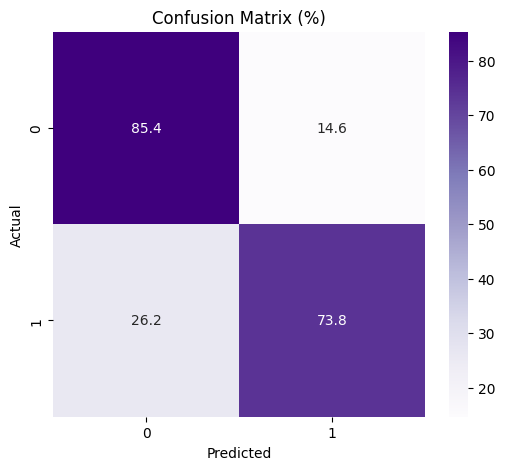

In [ ]:
from sklearn.metrics import confusion_matrix

# Test
y_true_test, y_pred_test = predict_with_loader(model, test_loader, device)
print("Test Accuracy: {:.2f}%".format(
    accuracy_score(y_true_test, y_pred_test) * 100
))

# Compute confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)

# Compute percentages
cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100

# Plot with percentages
plt.figure(figsize=(6,5))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Purples', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (%)')
plt.show()

# Free RAM
del y_true_val, y_pred_val, y_true_test, y_pred_test
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

AUC score: 0.8833883388338833


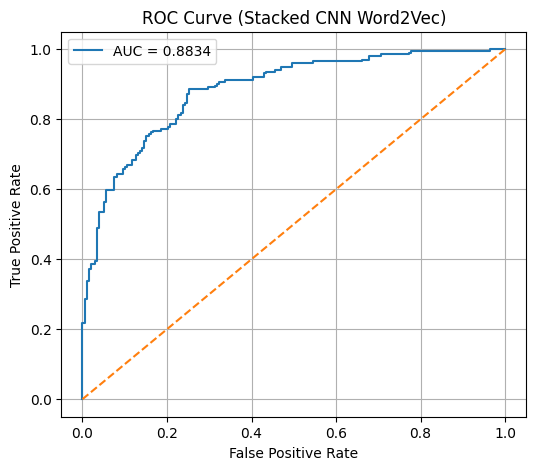

In [ ]:
from sklearn.metrics import roc_curve, auc
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Put model in eval mode
model.eval()

# Collect probabilities and labels
all_probs = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:   # use your test loader
        features = features.to('cuda')
        labels = labels.to('cuda')
        logits = model(features)      # raw model output
        probs = F.softmax(logits, dim=1)[:, 1]  # probability of class 1

        all_probs.append(probs.cpu())
        all_labels.append(labels.cpu())

# Convert to flat numpy arrays
all_probs = torch.cat(all_probs).numpy()
all_labels = torch.cat(all_labels).numpy()

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

# Compute AUC
auc_score = auc(fpr, tpr)
print("AUC score:", auc_score)

# Plot ROC curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Stacked CNN Word2Vec)")
plt.legend()
plt.grid(True)
plt.show()

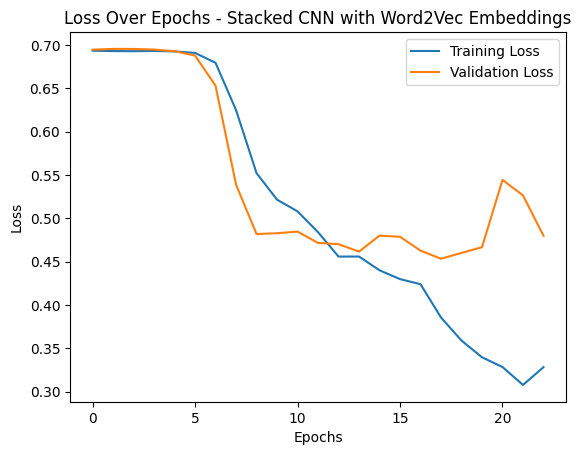

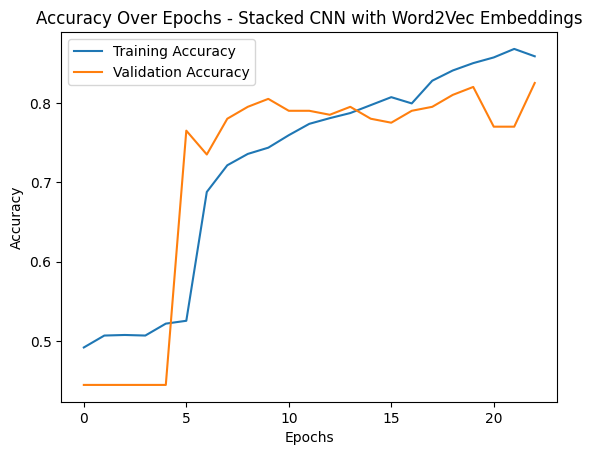

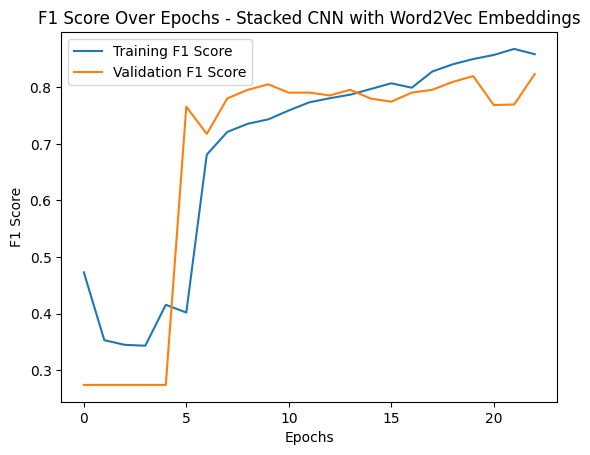

In [ ]:
plot_training_history(history, "Stacked CNN with Word2Vec Embeddings")

## Stacked CNN with Custom Embeddings

In [ ]:
# ======================
# Hyperparameter search space for CNN
# ======================
param_grid = {
    "filters": [64, 128],
    "kernel": [3, 5],
    "dense": [64, 128],
    "dropout_prob": [0.2, 0.4],
    "lr": [1e-3, 5e-4]
}

from itertools import product

keys = list(param_grid.keys())
configs = list(product(*param_grid.values()))

best_acc = -1
best_config = None
results = []

for cfg_values in configs:

    cfg = dict(zip(keys, cfg_values))
    print("\n==========================================")
    print("Training with config:", cfg)
    print("==========================================")

    # --------------------------
    # Build a CNN model with params
    # --------------------------
    model = Stacked_CNN(
        input_dim=EMBEDDING_DIM,
        n_classes=len(movies.target_names),
        dense=cfg["dense"],
        filters=cfg["filters"],
        kernel=cfg["kernel"],
        matrix_embeddings=None
    )

    # override dropout
    model.dropout = nn.Dropout(cfg["dropout_prob"])

    model.to(device)

    optimizer = Adam(model.parameters(), lr=cfg["lr"])
    criterion = torch.nn.CrossEntropyLoss()

    # --------------------------
    # Train with early stopping
    # --------------------------
    history, best_model_path = train_with_early_stopping(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        num_epochs=30,
        patience=5,
        model_name=f"grid_cnn_{hash(str(cfg))}",
        device=device,
    )

    val_acc = max(history["val_accuracy"])
    results.append((cfg, val_acc))

    print(f"VAL ACC: {val_acc:.4f}")

    # Track best
    if val_acc > best_acc:
        best_acc = val_acc
        best_config = cfg


print("\n==========================================")
print("BEST CONFIG:")
print(best_config)
print(f"BEST VAL ACC: {best_acc:.4f}")
print("==========================================")


Training with config: {'filters': 64, 'kernel': 3, 'dense': 64, 'dropout_prob': 0.2, 'lr': 0.001}
Epoch 1/30
  Train loss: 0.6935 | Val loss: 0.6964
  Train acc:  0.5064  | Val acc:  0.4450
  Train F1:   0.3405  | Val F1:   0.2741
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\grid_cnn_8514798063449256498_best_epoch_1.pth
Epoch 2/30
  Train loss: 0.6934 | Val loss: 0.6937
  Train acc:  0.4957  | Val acc:  0.4450
  Train F1:   0.4266  | Val F1:   0.2741
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\grid_cnn_8514798063449256498_best_epoch_2.pth
Epoch 3/30
  Train loss: 0.6935 | Val loss: 0.6943
  Train acc:  0.4979  | Val acc:  0.4450
  Train F1:   0.4839  | Val F1:   0.2741
  No improvement in val loss (1/5 epochs without improvement).
Epoch 4/30
  Train loss: 0.6926 | Val loss: 0.6919
  Train acc:  0.5086  | Val acc:  0.6250
  Train F1:   0.5013  | Val F1:   0.6252
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\grid_cnn_8

TRAIN BEST MODEL

In [ ]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

gc.collect()

0

In [ ]:
torch.manual_seed(1)

# Instantiate the model
model = Stacked_CNN(input_dim = EMBEDDING_DIM,
                          n_classes = 2,
                          dense = 128,
                          filters = 128,
                          kernel = 5,
                          matrix_embeddings = None
                   )

model.dropout = nn.Dropout(0.2)

print(model)

print(f"Total learnable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Stacked_CNN(
  (embedding_layer): Embedding(20002, 300, padding_idx=0)
  (conv1): Conv1d(300, 128, kernel_size=(5,), stride=(1,), padding=valid)
  (conv2): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=valid)
  (conv3): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=valid)
  (conv4): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=valid)
  (conv5): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=valid)
  (global_max_pool): AdaptiveMaxPool1d(output_size=1)
  (dense_layer): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Total learnable parameters: 6537690


In [ ]:
model.to(device)

optimizer = Adam(model.parameters(), lr = 0.0005)

criterion = nn.CrossEntropyLoss()
device = "cuda" # Set device to GPU if available

history, best_model_path = train_with_early_stopping(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=30,
    patience=5,                 # e.g. stop after 5 epochs with no dev improvement
    model_name="stacked_cnn_word2vec",
    device=device,
)

Epoch 1/30
  Train loss: 0.6936 | Val loss: 0.6948
  Train acc:  0.4950  | Val acc:  0.4450
  Train F1:   0.4713  | Val F1:   0.2741
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\stacked_cnn_word2vec_best_epoch_1.pth
Epoch 2/30
  Train loss: 0.6931 | Val loss: 0.6942
  Train acc:  0.4957  | Val acc:  0.4450
  Train F1:   0.4353  | Val F1:   0.2741
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\stacked_cnn_word2vec_best_epoch_2.pth
Epoch 3/30
  Train loss: 0.6929 | Val loss: 0.6954
  Train acc:  0.5100  | Val acc:  0.4450
  Train F1:   0.3920  | Val F1:   0.2741
  No improvement in val loss (1/5 epochs without improvement).
Epoch 4/30
  Train loss: 0.6925 | Val loss: 0.6931
  Train acc:  0.5214  | Val acc:  0.5050
  Train F1:   0.4780  | Val F1:   0.5053
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\stacked_cnn_word2vec_best_epoch_4.pth
Epoch 5/30
  Train loss: 0.6919 | Val loss: 0.6936
  Train acc:  0.5514  | Val acc:  0.

In [ ]:
# Set the model to evaluation mode
model.eval()

# Validation
y_true_val, y_pred_val = predict_with_loader(model, val_loader, device)
print("Validation Accuracy: {:.2f}%".format(
    accuracy_score(y_true_val, y_pred_val) * 100
))
print(classification_report(
    y_true_val, y_pred_val, target_names=movies.target_names
))

Validation Accuracy: 48.50%
              precision    recall  f1-score   support

         neg       0.56      0.32      0.41       111
         pos       0.45      0.69      0.54        89

    accuracy                           0.48       200
   macro avg       0.51      0.50      0.48       200
weighted avg       0.51      0.48      0.47       200



Test Accuracy: 59.00%


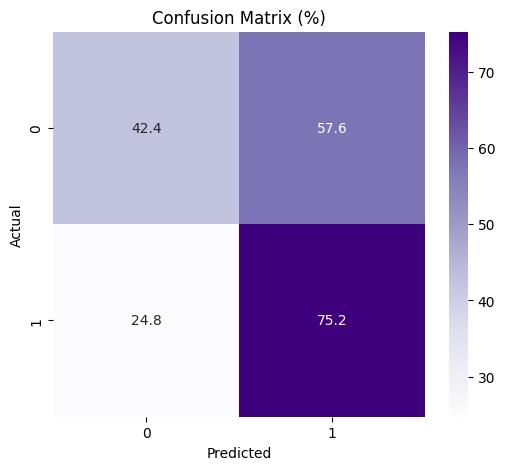

In [ ]:
from sklearn.metrics import confusion_matrix

# Test
y_true_test, y_pred_test = predict_with_loader(model, test_loader, device)
print("Test Accuracy: {:.2f}%".format(
    accuracy_score(y_true_test, y_pred_test) * 100
))

# Compute confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)

# Compute percentages
cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100

# Plot with percentages
plt.figure(figsize=(6,5))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Purples', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (%)')
plt.show()

# Free RAM
del y_true_val, y_pred_val, y_true_test, y_pred_test
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

AUC score: 0.6503900390039005


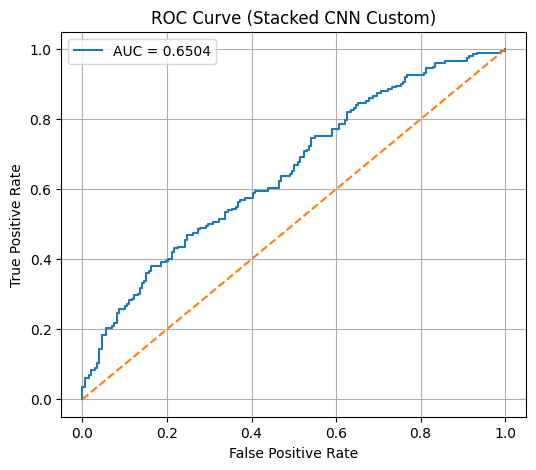

In [ ]:
from sklearn.metrics import roc_curve, auc
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Put model in eval mode
model.eval()

# Collect probabilities and labels
all_probs = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:   # use your test loader
        features = features.to('cuda')
        labels = labels.to('cuda')
        logits = model(features)      # raw model output
        probs = F.softmax(logits, dim=1)[:, 1]  # probability of class 1

        all_probs.append(probs.cpu())
        all_labels.append(labels.cpu())

# Convert to flat numpy arrays
all_probs = torch.cat(all_probs).numpy()
all_labels = torch.cat(all_labels).numpy()

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

# Compute AUC
auc_score = auc(fpr, tpr)
print("AUC score:", auc_score)

# Plot ROC curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Stacked CNN Custom)")
plt.legend()
plt.grid(True)
plt.show()

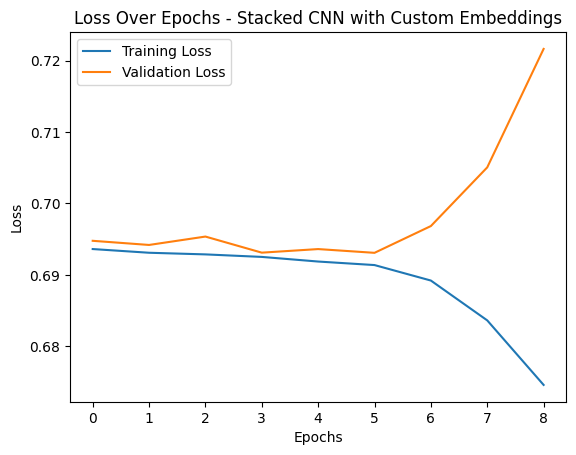

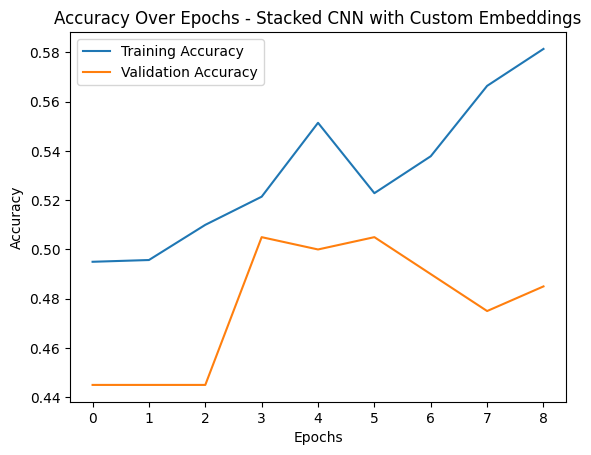

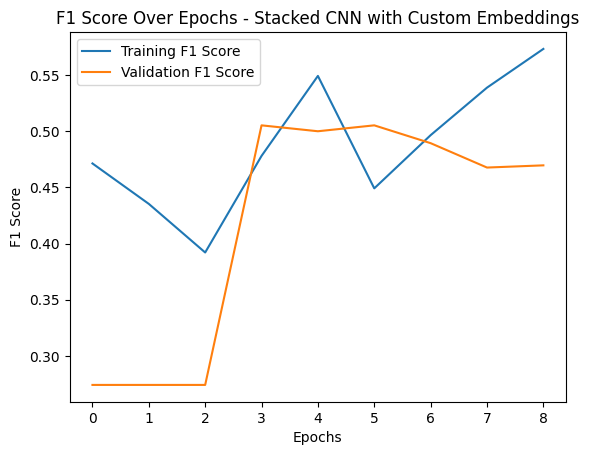

In [ ]:
plot_training_history(history, "Stacked CNN with Custom Embeddings")

## Create a model with stacked CNNs of 2-gram, 3-gram and 4-gram filters and residual connections

In [ ]:
FILTERS = 300  # the dimensionality of the output space (i.e. the number of output filters in the convolution)
N_CLASSES = 2

class Multikernel_CNN(nn.Module):
    def __init__(self, input_dim, n_classes, filters, matrix_embeddings = None):
        super(Multikernel_CNN, self).__init__()

        # dimensions
        self.input_dim = input_dim
        self.n_classes = n_classes
        self.filters = filters

        # Embedding layer
        if matrix_embeddings is not None:
            self.embedding_layer = nn.Embedding(num_embeddings = MAX_WORDS + 2, embedding_dim = EMBEDDING_DIM, padding_idx=0).from_pretrained(matrix_embeddings)
            self.embedding_layer.requires_grad = False # Don't change the embedding matrix
        else:
            self.embedding_layer = nn.Embedding(num_embeddings = MAX_WORDS + 2, embedding_dim = EMBEDDING_DIM, padding_idx=0)
            self.embedding_layer.requires_grad = True # Learn the embedding matrix


        self.bigram_conv1 = nn.Conv1d(in_channels = self.input_dim, out_channels = self.filters, kernel_size = 2, padding = "same")
        self.bigram_conv2 = nn.Conv1d(in_channels = self.filters, out_channels = self.filters, kernel_size = 2, padding = "same")

        self.trigram_conv1 = nn.Conv1d(in_channels = self.input_dim, out_channels = self.filters, kernel_size = 3, padding = "same")
        self.trigram_conv2 = nn.Conv1d(in_channels = self.filters, out_channels = self.filters, kernel_size = 3, padding = "same")

        self.tetragram_conv1 = nn.Conv1d(in_channels = self.input_dim, out_channels = self.filters, kernel_size = 4, padding = "same")
        self.tetragram_conv2 = nn.Conv1d(in_channels = self.filters, out_channels = self.filters, kernel_size = 4, padding = "same")

        self.global_max_pool = nn.AdaptiveMaxPool1d(output_size = 1)

        self.output = nn.Linear(in_features = 3 * self.filters, out_features = self.n_classes)

        self.dropout = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self, input):
        # Input shape: (batch_size, sequence_length)
        # Embedding layer
        x = self.embedding_layer(input.long()) # (batch_size, sequence_length, embedding_dim)

        # Dropout embeddings
        x = self.dropout(x) # (batch_size, sequence_length, embedding_dim)

        # Transpose to match the shape the Conv1d layer expects
        x = x.transpose(1,2)

        residual_bigram = residual_trigram = residual_tetragram = x # (batch_size, embedding_dim, sequence_length)

        # Stack of 1D convolutions with kernel of 2
        x_bigram = self.bigram_conv1(x) # (batch_size, filters, sequence_length)
        x_bigram = F.relu(x_bigram) # (batch_size, filters, sequence_length)
        # Add the residual connection
        x_bigram = x_bigram + residual_bigram # (batch_size, filters, sequence_length)
        # New residual connection
        residual_bigram = x_bigram # (batch_size, filters, sequence_length)
        x_bigram = self.bigram_conv2(x_bigram) # (batch_size, filters, sequence_length)
        x_bigram = F.relu(x_bigram) # (batch_size, filters, sequence_length)
        # Add the residual connection
        x_bigram = x_bigram + residual_bigram # (batch_size, filters, sequence_length)

        # Max pool
        x_bigram = self.global_max_pool(x_bigram) # (batch_size, filters, 1)
        x_bigram = x_bigram.squeeze(2) # (batch_size, filters)

        # Stack of 1D convolutions with kernel of 3
        x_trigram = self.trigram_conv1(x) # (batch_size, filters, sequence_length)
        x_trigram = F.relu(x_trigram) # (batch_size, filters, sequence_length)
        # Add the residual connection
        x_trigram = x_trigram + residual_trigram # (batch_size, filters, sequence_length)
        # New residual connection
        residual_trigram = x_trigram
        x_trigram = self.trigram_conv2(x_trigram) # (batch_size, filters, sequence_length)
        x_trigram = F.relu(x_trigram) # (batch_size, filters, sequence_length)
        # Add the residual connection
        x_trigram = x_trigram + residual_trigram # (batch_size, filters, sequence_length)

        # Max pool
        x_trigram = self.global_max_pool(x_trigram) # (batch_size, filters, 1)
        x_trigram = x_trigram.squeeze(2) # (batch_size, filters)

        # Stack of 1D convolutions with kernel of 4
        x_tetragram = self.tetragram_conv1(x) # (batch_size, filters, sequence_length)
        x_tetragram = F.relu(x_tetragram) # (batch_size, filters, sequence_length)
        # Add the residual connection
        x_tetragram = x_tetragram + residual_tetragram # (batch_size, filters, sequence_length)
        # New residual connection
        residual_tetragram = x_tetragram

        x_tetragram = self.tetragram_conv2(x_tetragram) # (batch_size, filters, sequence_length)
        x_tetragram = F.relu(x_tetragram) # (batch_size, filters, sequence_length)
        # Add the residual connection
        x_tetragram = x_tetragram + residual_tetragram # (batch_size, filters, sequence_length)

        # Max pool
        x_tetragram = self.global_max_pool(x_tetragram) # (batch_size, filters, 1)
        x_tetragram = x_tetragram.squeeze(2) # (batch_size, filters)

        x_concat = torch.cat([x_bigram, x_trigram, x_tetragram], dim=1) # (batch_size, filters * 3)
        #x_concat = self.dropout(x_concat) # (batch_size, filters * 3)
        x_concat = self.dropout2(x_concat) # (batch_size, filters * 3)

        logits = self.output(x_concat) # (batch_size, n_classes)

        return logits

multikernel_cnn = Multikernel_CNN(input_dim = EMBEDDING_DIM,
                          n_classes = N_CLASSES,
                          filters = FILTERS,
                          matrix_embeddings = torch.tensor(embedding_matrix, dtype = torch.float))

print(multikernel_cnn)

print(f"Total learnable parameters: {sum(p.numel() for p in multikernel_cnn.parameters() if p.requires_grad)}")

Multikernel_CNN(
  (embedding_layer): Embedding(20002, 300)
  (bigram_conv1): Conv1d(300, 300, kernel_size=(2,), stride=(1,), padding=same)
  (bigram_conv2): Conv1d(300, 300, kernel_size=(2,), stride=(1,), padding=same)
  (trigram_conv1): Conv1d(300, 300, kernel_size=(3,), stride=(1,), padding=same)
  (trigram_conv2): Conv1d(300, 300, kernel_size=(3,), stride=(1,), padding=same)
  (tetragram_conv1): Conv1d(300, 300, kernel_size=(4,), stride=(1,), padding=same)
  (tetragram_conv2): Conv1d(300, 300, kernel_size=(4,), stride=(1,), padding=same)
  (global_max_pool): AdaptiveMaxPool1d(output_size=1)
  (output): Linear(in_features=900, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)
Total learnable parameters: 1623602


In [ ]:
from itertools import product

# ============================
# Hyperparameter search space
# ============================
param_grid = {
    "dropout_prob": [0.2, 0.4],
    "lr": [1e-3, 5e-4]
}

keys = list(param_grid.keys())
configs = list(product(*param_grid.values()))

best_acc = -1
best_config = None
results = []

for cfg_values in configs:

    cfg = dict(zip(keys, cfg_values))
    print("\n==========================================")
    print("Training with config:", cfg)
    print("==========================================")

    # --------------------------
    # Build model with params
    # --------------------------
    model = Multikernel_CNN(
        input_dim=EMBEDDING_DIM,
        n_classes=2,
        filters=300,
        matrix_embeddings=torch.tensor(embedding_matrix, dtype = torch.float)
    )

    # Set dropout hyperparameter (two dropout layers)
    model.dropout = nn.Dropout(cfg["dropout_prob"])
    model.dropout2 = nn.Dropout(cfg["dropout_prob"])

    model.to(device)

    # Optimizer + loss
    optimizer = Adam(model.parameters(), lr=cfg["lr"])
    criterion = torch.nn.CrossEntropyLoss()

    # --------------------------
    # Train with early stopping
    # --------------------------
    history, best_model_path = train_with_early_stopping(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        num_epochs=30,
        patience=5,
        model_name=f"grid_multicnn_{hash(str(cfg))}",
        device=device
    )

    val_acc = max(history["val_accuracy"])
    results.append((cfg, val_acc))

    print(f"VAL ACC: {val_acc:.4f}")

    # Track best
    if val_acc > best_acc:
        best_acc = val_acc
        best_config = cfg


print("\n==========================================")
print("BEST CONFIG:")
print(best_config)
print(f"BEST VAL ACC: {best_acc:.4f}")
print("==========================================")


Training with config: {'dropout_prob': 0.2, 'lr': 0.001}


C:\FORMAT LAP HP\jim\CS\NLP\exercises\Lib\site-packages\torch\nn\modules\conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:1037.)
  return F.conv1d(


Epoch 1/30
  Train loss: 0.8157 | Val loss: 0.6794
  Train acc:  0.4871  | Val acc:  0.5550
  Train F1:   0.4833  | Val F1:   0.3962
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\grid_multicnn_-8049086863615354479_best_epoch_1.pth
Epoch 2/30
  Train loss: 0.6875 | Val loss: 0.6828
  Train acc:  0.5407  | Val acc:  0.4750
  Train F1:   0.5275  | Val F1:   0.3575
  No improvement in val loss (1/5 epochs without improvement).
Epoch 3/30
  Train loss: 0.6462 | Val loss: 0.6538
  Train acc:  0.5929  | Val acc:  0.5950
  Train F1:   0.5676  | Val F1:   0.5653
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\grid_multicnn_-8049086863615354479_best_epoch_3.pth
Epoch 4/30
  Train loss: 0.5866 | Val loss: 0.6078
  Train acc:  0.6829  | Val acc:  0.7600
  Train F1:   0.6556  | Val F1:   0.7463
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\grid_multicnn_-8049086863615354479_best_epoch_4.pth
Epoch 5/30
  Train loss: 0.5291 | Val loss: 0

In [ ]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

gc.collect()

7255

In [ ]:
torch.manual_seed(1)

# Instantiate the model
model = Multikernel_CNN(
    input_dim=EMBEDDING_DIM,
    n_classes=2,
    filters=300,
    matrix_embeddings=torch.tensor(embedding_matrix, dtype = torch.float)
)

model.dropout = nn.Dropout(0.2)

print(model)

print(f"Total learnable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Multikernel_CNN(
  (embedding_layer): Embedding(20002, 300)
  (bigram_conv1): Conv1d(300, 300, kernel_size=(2,), stride=(1,), padding=same)
  (bigram_conv2): Conv1d(300, 300, kernel_size=(2,), stride=(1,), padding=same)
  (trigram_conv1): Conv1d(300, 300, kernel_size=(3,), stride=(1,), padding=same)
  (trigram_conv2): Conv1d(300, 300, kernel_size=(3,), stride=(1,), padding=same)
  (tetragram_conv1): Conv1d(300, 300, kernel_size=(4,), stride=(1,), padding=same)
  (tetragram_conv2): Conv1d(300, 300, kernel_size=(4,), stride=(1,), padding=same)
  (global_max_pool): AdaptiveMaxPool1d(output_size=1)
  (output): Linear(in_features=900, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)
Total learnable parameters: 1623602


In [ ]:
model.to(device)

optimizer = Adam(model.parameters(), lr = 0.0005)

criterion = nn.CrossEntropyLoss()
device = "cuda" # Set device to GPU if available

history, best_model_path = train_with_early_stopping(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=30,
    patience=5,
    model_name=f"grid_multicnn_{hash(str(cfg))}",
    device=device
)

Epoch 1/30
  Train loss: 0.7512 | Val loss: 0.7126
  Train acc:  0.5071  | Val acc:  0.4450
  Train F1:   0.4895  | Val F1:   0.2741
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\grid_multicnn_-4045913395822479644_best_epoch_1.pth
Epoch 2/30
  Train loss: 0.6760 | Val loss: 0.6638
  Train acc:  0.5657  | Val acc:  0.5550
  Train F1:   0.5095  | Val F1:   0.3962
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\grid_multicnn_-4045913395822479644_best_epoch_2.pth
Epoch 3/30
  Train loss: 0.6511 | Val loss: 0.6620
  Train acc:  0.5964  | Val acc:  0.6050
  Train F1:   0.5669  | Val F1:   0.5884
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\grid_multicnn_-4045913395822479644_best_epoch_3.pth
Epoch 4/30
  Train loss: 0.6132 | Val loss: 0.6292
  Train acc:  0.6986  | Val acc:  0.7050
  Train F1:   0.6918  | Val F1:   0.6683
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\grid_multicnn_-4045913395822479644_best_

In [ ]:
# Set the model to evaluation mode
model.eval()

# Validation
y_true_val, y_pred_val = predict_with_loader(model, val_loader, device)
print("Validation Accuracy: {:.2f}%".format(
    accuracy_score(y_true_val, y_pred_val) * 100
))
print(classification_report(
    y_true_val, y_pred_val, target_names=movies.target_names
))

Validation Accuracy: 85.00%
              precision    recall  f1-score   support

         neg       0.84      0.90      0.87       111
         pos       0.86      0.79      0.82        89

    accuracy                           0.85       200
   macro avg       0.85      0.84      0.85       200
weighted avg       0.85      0.85      0.85       200



Test Accuracy: 85.00%


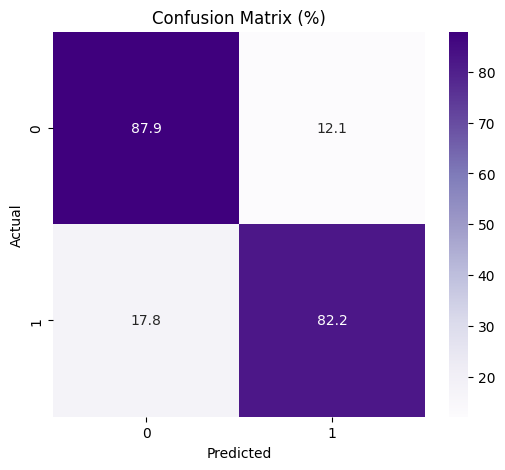

In [ ]:
from sklearn.metrics import confusion_matrix

# Test
y_true_test, y_pred_test = predict_with_loader(model, test_loader, device)
print("Test Accuracy: {:.2f}%".format(
    accuracy_score(y_true_test, y_pred_test) * 100
))

# Compute confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)

# Compute percentages
cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100

# Plot with percentages
plt.figure(figsize=(6,5))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Purples', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (%)')
plt.show()

# Free RAM
del y_true_val, y_pred_val, y_true_test, y_pred_test
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

AUC score: 0.9274427442744274


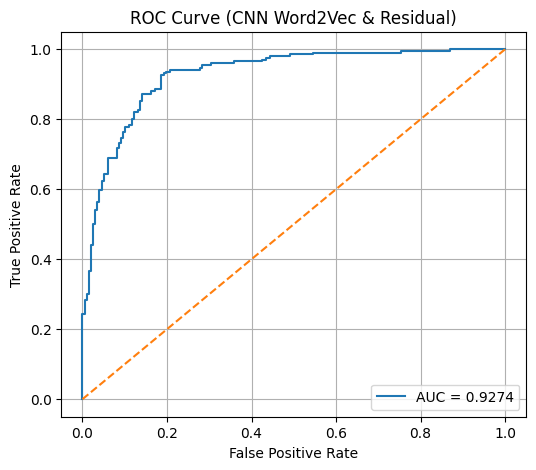

In [ ]:
from sklearn.metrics import roc_curve, auc
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Put model in eval mode
model.eval()

# Collect probabilities and labels
all_probs = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:   # use your test loader
        features = features.to('cuda')
        labels = labels.to('cuda')
        logits = model(features)      # raw model output
        probs = F.softmax(logits, dim=1)[:, 1]  # probability of class 1

        all_probs.append(probs.cpu())
        all_labels.append(labels.cpu())

# Convert to flat numpy arrays
all_probs = torch.cat(all_probs).numpy()
all_labels = torch.cat(all_labels).numpy()

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

# Compute AUC
auc_score = auc(fpr, tpr)
print("AUC score:", auc_score)

# Plot ROC curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (CNN Word2Vec & Residual)")
plt.legend()
plt.grid(True)
plt.show()

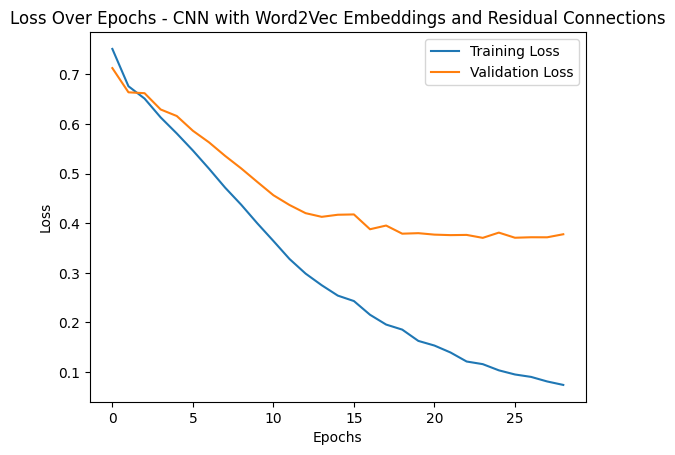

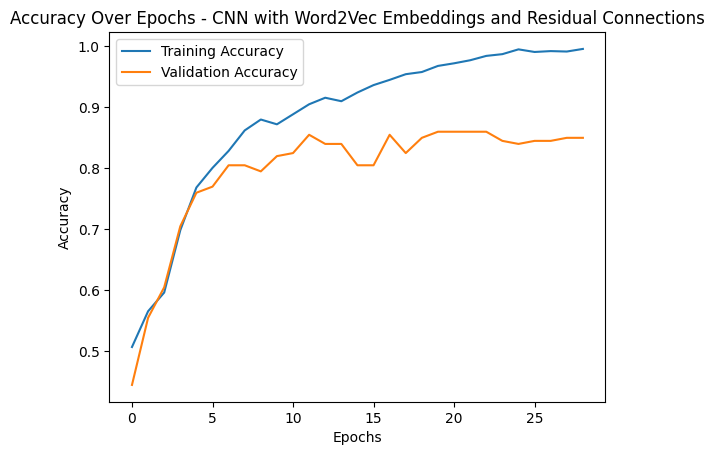

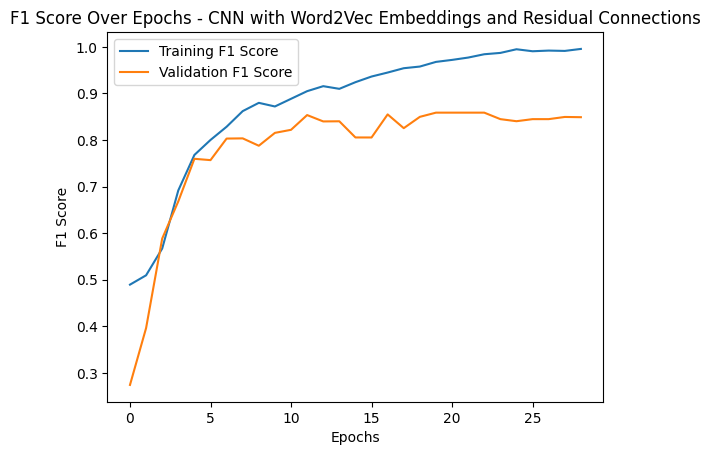

In [ ]:
plot_training_history(history, "CNN with Word2Vec Embeddings and Residual Connections")

# Final Results in movies

|                   Model Name                      |Epochs Trained|Val Accuracy %|Test Accuracy %|
|---------------------------------------------------|--------------|--------------|---------------|
|Stacked CNN with Word2Vec Embeddings               |      23      |82.50         |79.50          |
|Stacked CNN with Custom Embeddings                 |      9       |48.50         |59.00          |
|CNN with Word2Vec & Residual Connections           |      29      |**85.00**     |**85.00**      |